## Importing required libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from nltk.tokenize import word_tokenize
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt

# ignoring all the future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uk42\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uk42\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Task 1: Sentence contain Propagada or not

## Preprocessing text

In [2]:
def preprocess_text(text):
    # Remove <BOS> and <EOS> tokens
    text = text.replace("<BOS>", "").replace("<EOS>", "")
    # Remove punctuation and special characters
    text = re.sub(r"[^\w\s]", "", text)
    # Lowercase the text
    text = text.lower()
    return text

## Loading and Preprocessing Data

In [3]:
# Load data
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')
test_data = pd.read_csv('propaganda_val.tsv', sep="\t")

# Changing the column names
train_data.columns = ["label", "sentence"]
test_data.columns = ["label", "sentence"]

## Appraoch 1: Bag of words classifier

In [4]:
# Changing all the 'label' name to 'propaganda' other than 'not propaganda'
train_data['propaganda'] = train_data['label'].apply(lambda x: "propaganda" if x != 'not_propaganda' else "not propaganda")
test_data['propaganda'] = test_data['label'].apply(lambda x: "propaganda" if x != 'not_propaganda' else "not propaganda")

train_data['processed_sentence'] = train_data['sentence'].apply(preprocess_text)
test_data['processed_sentence'] = test_data['sentence'].apply(preprocess_text)

train_data['tokenized_sentence'] = train_data['processed_sentence'].apply(word_tokenize)
test_data['tokenized_sentence'] = test_data['processed_sentence'].apply(word_tokenize)

tfidf_vectorizer = TfidfVectorizer(max_features=800) #Adjust max_features as needed
X_train = tfidf_vectorizer.fit_transform(train_data['processed_sentence'])
X_test = tfidf_vectorizer.transform(test_data['processed_sentence'])

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['propaganda'])
y_test = label_encoder.transform(test_data['propaganda'])

# Train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predictions on the testing set
test_predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, test_predictions)
report = classification_report(y_test, test_predictions, target_names=label_encoder.classes_)
print(report)

                precision    recall  f1-score   support

not propaganda       0.70      0.68      0.69       301
    propaganda       0.67      0.69      0.68       279

      accuracy                           0.69       580
     macro avg       0.69      0.69      0.69       580
  weighted avg       0.69      0.69      0.69       580



## Approach 2: Pretrained large language model

## BERT Classifier Model Definition

In [5]:
class BertClassifier(nn.Module):
    
    def __init__(self, dropout=0.5, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        last_hidden_layer, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

## Preparing Data and Labels for BERT Classification

In [6]:
# Preprocessing text
train_data['processed_sentence'] = train_data['sentence'].apply(preprocess_text)
test_data['processed_sentence'] = test_data['sentence'].apply(preprocess_text)

# Changing all the 'label' name to 'propaganda' other than 'not propaganda'
train_data['propaganda'] = train_data['label'].apply(lambda x: "propaganda" if x != 'not_propaganda' else "not propaganda")
test_data['propaganda'] = test_data['label'].apply(lambda x: "propaganda" if x != 'not_propaganda' else "not propaganda")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = tokenizer(list(train_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test = tokenizer(list(test_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)

label_encoder = LabelEncoder()
train_data['propaganda'] = label_encoder.fit_transform(train_data['propaganda'])
test_data['propaganda'] = label_encoder.transform(test_data['propaganda'])
y_train = torch.tensor(train_data['propaganda'], dtype=torch.long)
y_test = torch.tensor(test_data['propaganda'], dtype=torch.long)

train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)


## Training and Evaluating BERT Classifier

In [7]:
def prepare_inputs(input_ids, attention_mask, labels, device):
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    return input_ids, attention_mask, labels

def train_and_evaluate(model, train_data, val_data, learning_rate, epochs):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_batch_size = 2
    test_batch_size = 4
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
        for batch in tqdm(train_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_acc_train += (predicted == labels).sum().item()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        val_dataloader = DataLoader(val_data, batch_size=test_batch_size)
        true_labels = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                total_loss_val += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_acc_val += (predicted == labels).sum().item()
                true_labels.extend(labels.tolist())
                predictions.extend(predicted.tolist())

        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary', zero_division=1)
        report = classification_report(true_labels, predictions) 
        print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train / len(train_data):.3f}')
        print(f'Val loss: {total_loss_val / len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        print("BERT Classifier Accuracy:", accuracy)
        print(report)
        # Append metrics for plotting
        train_losses.append(total_loss_train / len(train_data))
        train_accuracies.append(total_acc_train / len(train_data))
        val_losses.append(total_loss_val / len(val_data))
        val_accuracies.append(total_acc_val / len(val_data))

## Training BERT Classifier

In [8]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize BERT Classifier
classifier = BertClassifier(num_classes=len(label_encoder.classes_))
num_epochs = 2
learning_rates = 1e-5

# Train the model
train_and_evaluate(classifier, train_dataset, test_dataset, learning_rate=learning_rates, epochs=num_epochs)

100%|██████████| 145/145 [00:02<00:00, 63.41it/s]


Epochs: 1 | Train Loss: 0.293 | Train Accuracy: 0.692
Val loss: 0.151 | Val Accuracy: 0.674
BERT Classifier Accuracy: 0.6741379310344827
              precision    recall  f1-score   support

           0       0.83      0.47      0.60       301
           1       0.61      0.89      0.72       279

    accuracy                           0.67       580
   macro avg       0.72      0.68      0.66       580
weighted avg       0.72      0.67      0.66       580



100%|██████████| 145/145 [00:02<00:00, 63.14it/s]

Epochs: 2 | Train Loss: 0.203 | Train Accuracy: 0.822
Val loss: 0.126 | Val Accuracy: 0.772
BERT Classifier Accuracy: 0.7724137931034483
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       301
           1       0.78      0.73      0.75       279

    accuracy                           0.77       580
   macro avg       0.77      0.77      0.77       580
weighted avg       0.77      0.77      0.77       580



## Plotting Training and Validation Metrics

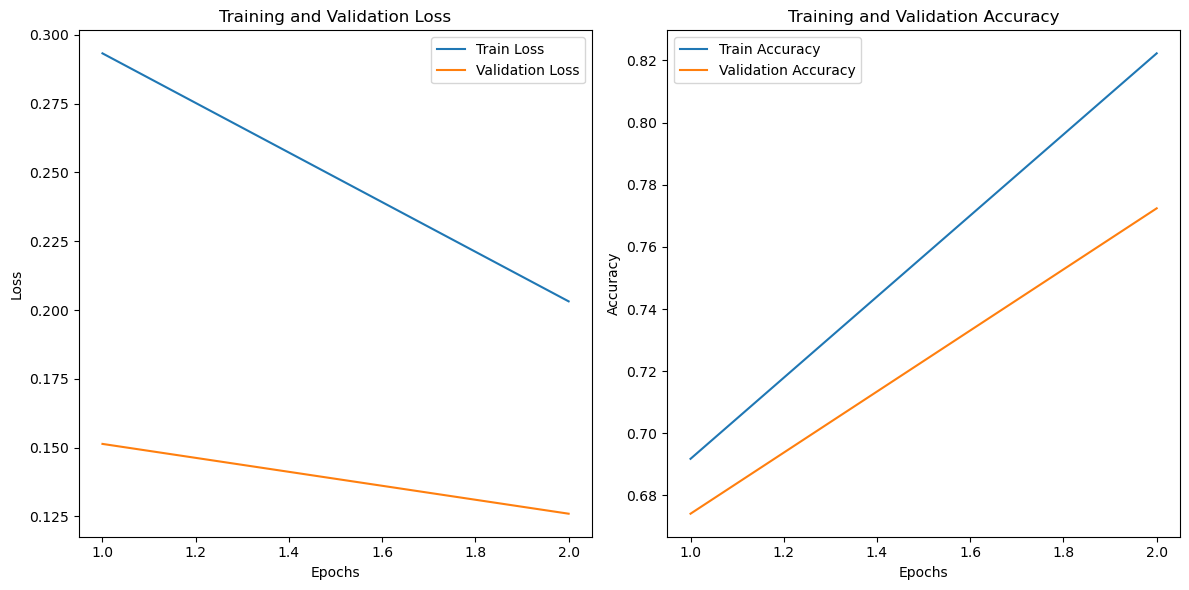

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Task 2: Propaganda Snippet

## Preprocessing text

In [10]:
def preprocess_text(text):
    # Extract text within <BOS> and <EOS> tokens
    match = re.search(r'<BOS>(.*?)<EOS>', text)
    if match:
        extracted_text = match.group(1)
    else:
        extracted_text = text
    # Remove punctuation and special characters
    extracted_text = re.sub(r"[^\w\s]", "", extracted_text)
    # Lowercase the text
    extracted_text = extracted_text.lower()
    return extracted_text

## Loading and Preprocessing Data

In [11]:
# Load data
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')
test_data = pd.read_csv('propaganda_val.tsv', sep="\t")

# Changing the column names
train_data.columns = ["label", "sentence"]
test_data.columns = ["label", "sentence"]

## Appraoch 1: Bag of words classifier

In [12]:
# Drop rows where 'label' field is 'not_propaganda'
train_data = train_data[train_data['label'] != 'not_propaganda']
test_data = test_data[test_data['label'] != 'not_propaganda']

train_data['processed_sentence'] = train_data['sentence'].apply(preprocess_text)
test_data['processed_sentence'] = test_data['sentence'].apply(preprocess_text)

train_data['tokenized_sentence'] = train_data['processed_sentence'].apply(word_tokenize)
test_data['tokenized_sentence'] = test_data['processed_sentence'].apply(word_tokenize)

tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed
X_train = tfidf_vectorizer.fit_transform(train_data['processed_sentence'])
X_test = tfidf_vectorizer.transform(test_data['processed_sentence'])

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

# Train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predictions on the testing set
test_predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, test_predictions)
report = classification_report(y_test, test_predictions, target_names=label_encoder.classes_)
print(report)

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.54      0.49      0.51        43
causal_oversimplification       0.30      0.52      0.38        31
                    doubt       0.44      0.39      0.42        38
exaggeration,minimisation       0.36      0.32      0.34        28
              flag_waving       0.75      0.62      0.68        39
          loaded_language       0.44      0.62      0.52        37
    name_calling,labeling       0.52      0.39      0.44        31
               repetition       0.60      0.38      0.46        32

                 accuracy                           0.47       279
                macro avg       0.49      0.46      0.47       279
             weighted avg       0.50      0.47      0.48       279



## Approach 2: Pretrained large language model

## BERT Classifier Model Definition

In [13]:
class BertClassifier(nn.Module):
    
    def __init__(self, dropout=0.5, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        last_hidden_layer, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

## Preparing Data and Labels for BERT Classification

In [17]:
# Preprocessing text
train_data['processed_sentence'] = train_data['sentence'].apply(preprocess_text)
test_data['processed_sentence'] = test_data['sentence'].apply(preprocess_text)

# Drop rows where 'label' field is 'not_propaganda'
train_data = train_data[train_data['label'] != 'not_propaganda']
test_data = test_data[test_data['label'] != 'not_propaganda']

# Tokenize and encode the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = tokenizer(list(train_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test = tokenizer(list(test_data['processed_sentence']), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Encode labels
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
test_data['encoded_label'] = label_encoder.transform(test_data['label'])

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_data['encoded_label'].values, dtype=torch.long)
test_labels_tensor = torch.tensor(test_data['encoded_label'].values, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], test_labels_tensor)

## Training and Evaluating BERT Classifier

In [18]:
def prepare_inputs(input_ids, attention_mask, labels, device):
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    return input_ids, attention_mask, labels

# Train and evaluate function
def train_and_evaluate(model, train_data, val_data, learning_rate, epochs):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
        for batch in tqdm(train_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_acc_train += (predicted == labels).sum().item()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        val_dataloader = DataLoader(val_data, batch_size=2)
        true_labels = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = prepare_inputs(input_ids, attention_mask, labels, device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                total_loss_val += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_acc_val += (predicted == labels).sum().item()

                true_labels.extend(labels.tolist())
                predictions.extend(predicted.tolist())

        # Calculate evaluation metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
        report = classification_report(true_labels, predictions) 
        print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train / len(train_data):.3f}')
        print(f'Val loss: {total_loss_val / len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        print("BERT Classifier Accuracy:", accuracy)
        print(report)
        # Append metrics for plotting
        train_losses.append(total_loss_train / len(train_data))
        train_accuracies.append(total_acc_train / len(train_data))
        val_losses.append(total_loss_val / len(val_data))
        val_accuracies.append(total_acc_val / len(val_data))

## Training BERT Classifier

In [19]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize BERT Classifier
classifier = BertClassifier(num_classes=len(label_encoder.classes_))
num_epochs = 4
learning_rates = 2e-5

# Train the model
train_and_evaluate(classifier, train_dataset, test_dataset, learning_rate=learning_rates, epochs=num_epochs)

100%|██████████| 140/140 [00:01<00:00, 91.00it/s]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epochs: 1 | Train Loss: 0.490 | Train Accuracy: 0.219
Val loss: 0.902 | Val Accuracy: 0.305
BERT Classifier Accuracy: 0.3046594982078853
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.23      1.00      0.38        31
           2       0.40      0.11      0.17        38
           3       0.38      0.32      0.35        28
           4       0.00      0.00      0.00        39
           5       0.58      0.19      0.29        37
           6       0.39      0.61      0.47        31
           7       0.29      0.47      0.36        32

    accuracy                           0.30       279
   macro avg       0.28      0.34      0.25       279
weighted avg       0.27      0.30      0.23       279



100%|██████████| 140/140 [00:01<00:00, 90.49it/s]


Epochs: 2 | Train Loss: 0.387 | Train Accuracy: 0.442
Val loss: 0.734 | Val Accuracy: 0.452
BERT Classifier Accuracy: 0.45161290322580644
              precision    recall  f1-score   support

           0       0.71      0.12      0.20        43
           1       0.30      0.65      0.41        31
           2       0.45      0.68      0.54        38
           3       0.37      0.39      0.38        28
           4       0.84      0.41      0.55        39
           5       0.52      0.43      0.47        37
           6       0.55      0.77      0.64        31
           7       0.35      0.25      0.29        32

    accuracy                           0.45       279
   macro avg       0.51      0.46      0.44       279
weighted avg       0.53      0.45      0.43       279



100%|██████████| 140/140 [00:01<00:00, 91.57it/s]


Epochs: 3 | Train Loss: 0.259 | Train Accuracy: 0.663
Val loss: 0.593 | Val Accuracy: 0.606
BERT Classifier Accuracy: 0.6057347670250897
              precision    recall  f1-score   support

           0       0.63      0.56      0.59        43
           1       0.62      0.48      0.55        31
           2       0.60      0.71      0.65        38
           3       0.57      0.43      0.49        28
           4       0.72      0.87      0.79        39
           5       0.53      0.57      0.55        37
           6       0.61      0.74      0.67        31
           7       0.50      0.41      0.45        32

    accuracy                           0.61       279
   macro avg       0.60      0.60      0.59       279
weighted avg       0.60      0.61      0.60       279



100%|██████████| 140/140 [00:01<00:00, 91.38it/s]

Epochs: 4 | Train Loss: 0.161 | Train Accuracy: 0.815
Val loss: 0.575 | Val Accuracy: 0.649
BERT Classifier Accuracy: 0.6487455197132617
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        43
           1       0.64      0.68      0.66        31
           2       0.59      0.63      0.61        38
           3       0.52      0.54      0.53        28
           4       0.86      0.77      0.81        39
           5       0.61      0.73      0.67        37
           6       0.69      0.71      0.70        31
           7       0.61      0.44      0.51        32

    accuracy                           0.65       279
   macro avg       0.65      0.64      0.64       279
weighted avg       0.65      0.65      0.65       279



## Plotting Training and Validation Metrics

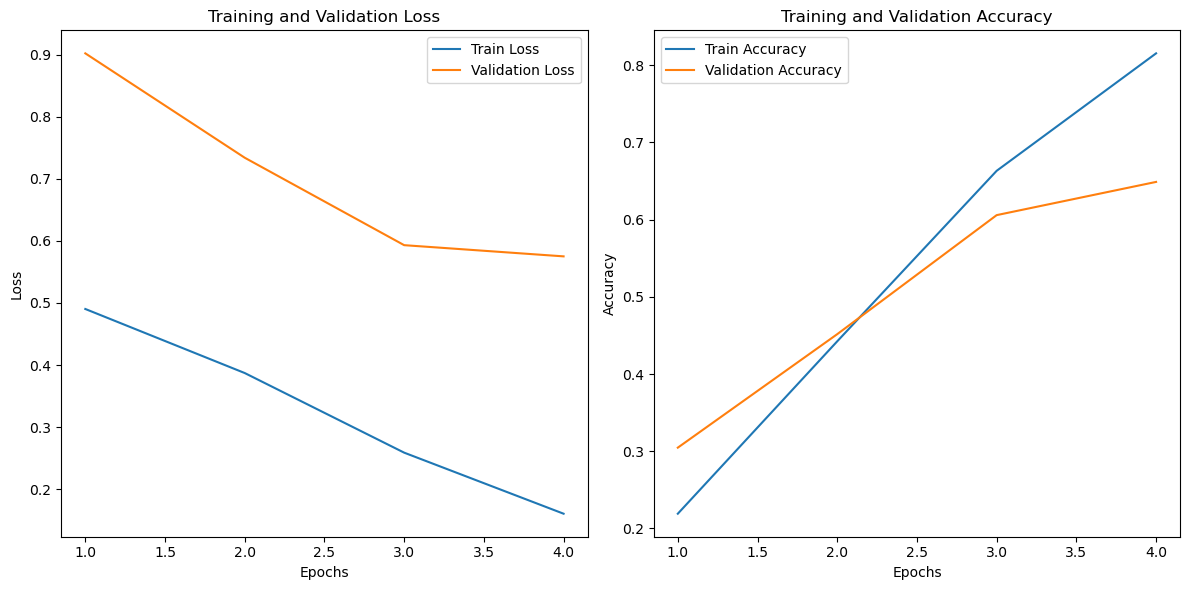

In [20]:
# Plotting
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
